# Feature Engineering Homework 
***
**Name**: $<$Akriti Kapur$>$ 

**Kaggle Username**: $<$akritikapur$>$
***

This assignment is due on Moodle by **5pm on Friday February 23rd**. Additionally, you must make at least one submission to the **Kaggle** competition before it closes at **4:59pm on Friday February 23rd**. Submit only this Jupyter notebook to Moodle. Do not compress it using tar, rar, zip, etc. Your solutions to analysis questions should be done in Markdown directly below the associated question.  Remember that you are encouraged to discuss the problems with your instructors and classmates, but **you must write all code and solutions on your own**.  For a refresher on the course **Collaboration Policy** click [here](https://github.com/chrisketelsen/CSCI5622-Machine-Learning/blob/master/resources/syllabus.md#collaboration-policy)



## Overview 
***

When people are discussing popular media, there’s a concept of spoilers. That is, critical information about the plot of a TV show, book, or movie that “ruins” the experience for people who haven’t read / seen it yet.

The goal of this assignment is to do text classification on forum posts from the website [tvtropes.org](http://tvtropes.org/), to predict whether a post is a spoiler or not. We'll be using the logistic regression classifier provided by sklearn.

Unlike previous assignments, the code provided with this assignment has all of the functionality required. Your job is to make the functionality better by improving the features the code uses for text classification.

**NOTE**: Because the goal of this assignment is feature engineering, not classification algorithms, you may not change the underlying algorithm or it's parameters

This assignment is structured in a way that approximates how classification works in the real world: Features are typically underspecified (or not specified at all). You, the data digger, have to articulate the features you need. You then compete against others to provide useful predictions.

It may seem straightforward, but do not start this at the last minute. There are often many things that go wrong in testing out features, and you'll want to make sure your features work well once you've found them.


## Kaggle In-Class Competition 
***

In addition to turning in this notebook on Moodle, you'll also need to submit your predictions on Kaggle, an online tournament site for machine learning competitions. The competition page can be found here:  

[https://www.kaggle.com/c/feature-engineering-csci-5622-spring-2018](https://www.kaggle.com/c/feature-engineering-csci-5622-spring-2018)

Additionally, a private invite link for the competition has been posted to Piazza. 

The starter code below has a `model_predict` method which produces a two column CSV file that is correctly formatted for Kaggle (predictions.csv). It should have the example Id as the first column and the prediction (`True` or `False`) as the second column. If you change this format your submissions will be scored as zero accuracy on Kaggle. 

**Note**: You may only submit **THREE** predictions to Kaggle per day.  Instead of using the public leaderboard as your sole evaluation processes, it is highly recommended that you perform local evaluation using a validation set or cross-validation. 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline 

### [25 points] Problem 1: Feature Engineering 
***

The `FeatEngr` class is where the magic happens.  In it's current form it will read in the training data and vectorize it using simple Bag-of-Words.  It then trains a model and makes predictions.  

25 points of your grade will be generated from your performance on the the classification competition on Kaggle. The performance will be evaluated on accuracy on the held-out test set. Half of the test set is used to evaluate accuracy on the public leaderboard.  The other half of the test set is used to evaluate accuracy on the private leaderboard (which you will not be able to see until the close of the competition). 

You should be able to significantly improve on the baseline system (i.e. the predictions made by the starter code we've provided) as reported by the Kaggle system.  Additionally, the top **THREE** students from the **PRIVATE** leaderboard at the end of the contest will receive 5 extra credit points towards their Problem 1 score.


In [4]:
import numpy as np
import nltk
import pandas as pd
import matplotlib.pylab as plt


from sklearn.model_selection import KFold, cross_val_score, train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, auc, confusion_matrix, make_scorer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

from scipy import sparse
from scipy.sparse import csr_matrix

from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from nltk import ne_chunk, pos_tag
from nltk.chunk import conlltags2tree, tree2conlltags

def lemmatize(sentence):
    from nltk.stem import WordNetLemmatizer

    lemmer = WordNetLemmatizer()
    return ' '.join([lemmer.lemmatize(word) for word in word_tokenize(sentence)])


def stemmer(sentence):
    from nltk.stem.snowball import SnowballStemmer

    stemmer = SnowballStemmer('english')
    return ' '.join([stemmer.stem(word) for word in sentence.split(' ')])


def extract_emotion_features():
    feat = ['anger', 'anxiety', 'negative_affect', 'positive_affect', 'sadness', 'swear']
    features = {}
    for i in feat:
        with open("../data/LIWC/{}".format(i), 'r+') as f:
            data = f.readlines()
            features[i] = [line.strip()[:-1] if line.strip()[-1] == '*' else line.strip() for line in data]

    return features


def count_named_entities(examples):
    X = np.zeros((len(examples), 1))

    # Loop over examples and count words
    for ii, x in enumerate(examples):
        ne_tree = ne_chunk(pos_tag(word_tokenize(x)))
        iob_tagged = tree2conlltags(ne_tree)
        iob = [iob[2] for iob in iob_tagged]
        X[ii, 0] = iob.count('B-PERSON') + iob.count('B-ORGANIZATION')

    return X


def count_tense(examples):
    tense = [['VBN', 'VBD'], ['VBG', 'VBP', 'VBZ']]
    X = np.zeros((len(examples), 3))

    # Loop over examples and count words
    for ii, x in enumerate(examples):
        pos_tagged = pos_tag(word_tokenize(x))
        pos_tagged = [tag[1] for tag in pos_tagged]
        past = sum(pos_tagged.count(i) for i in tense[0])
        present = sum(pos_tagged.count(i) for i in tense[1])
        other = pos_tagged.count('VB')

        X[ii, :] = [past, present, other]

    return X


def get_metrics():
    dfTrain = pd.read_csv("../data/spoilers/train.csv")
    dfTrain_y = np.array(dfTrain["spoiler"], dtype=int)
    dfTest = pd.read_csv("../data/spoilers/test.csv")

    spoiler_train = dfTrain[dfTrain["spoiler"] == 1]
    non_spoiler_train = dfTrain[dfTrain["spoiler"] == 0]

    print(count_named_entities(spoiler_train["sentence"]).mean())
    print(count_named_entities(non_spoiler_train["sentence"]).mean())

    print(count_tense(spoiler_train["sentence"]).mean(axis=0))
    print(count_tense(non_spoiler_train["sentence"]).mean(axis=0))


def cross_validate(features):
    dfTrain = pd.read_csv("../data/spoilers/train.csv")
    dfTrain_y = np.array(dfTrain["spoiler"], dtype=int)
    dfTest = pd.read_csv("../data/spoilers/test.csv")

    bag_of_words_vectorizer = TfidfVectorizer(analyzer='char_wb', ngram_range=(2, 9), stop_words='english',
                                              max_features=600)
    word_vectorizer = TfidfVectorizer(ngram_range=(1, 2), stop_words='english', max_features=600)
    vectorizer = FeatureUnion([
        ("bag-of-words", word_vectorizer),
        ("character-ngram", bag_of_words_vectorizer),
    ])

    trope_vector = FeatureUnion([
        ("character-ngrams", TfidfVectorizer(analyzer='char_wb', ngram_range=(5, 10), max_features=600)),
        ("bag-of-words", TfidfVectorizer(max_features=600))
    ])

    vectorizer_unioned = FeatureUnion(
        transformer_list=[
            # Pipeline for pulling features from the post's subject line
            ('sentence', Pipeline([
                ('selector', ItemSelector(key='sentence')),
                ('vectorizer', vectorizer),
            ])),
            # Pipeline for taking length of sentence
            ('EmotionCounts', Pipeline([
                ('selector', ItemSelector(key='sentence')),
                ('transformer', EmotionTransformer(None)),
            ])),
            # Pipeline for counting occurences of top feature words of sentence
            ('wordCounts', Pipeline([
                ('selector', ItemSelector(key='sentence')),
                ('transformer', WordTransformer(lemmatize, stemmer, csr_matrix)),
            ])),
            # Pipeline for counting tense for sentence
            ('NER', Pipeline([
                ('selector', ItemSelector(key='sentence')),
                ('transformer', NERTransformer()),
            ])),
            # Pipeline for counting tense for sentence
            ('TenseVerbCounts', Pipeline([
                ('selector', ItemSelector(key='sentence')),
                ('transformer', TenseTransformer()),
            ])),
            # Pipeline for standard bag-of-words model for trope
            ('trope', Pipeline([
                ('selector', ItemSelector(key='trope')),
                ('tfidf', trope_vector),
            ])),
        ],
    )

    pipe = Pipeline([
        ('tfid', vectorizer_unioned),
        ('chi2', SelectKBest(chi2, 1000)),
        ('classifier', LogisticRegression(random_state=1234))
    ])

    # N_FEATURES_OPTIONS = ['all']
    # param_grid = [
    #     {
    #         'chi2__k': N_FEATURES_OPTIONS,
    #     },
    # ]

    # load data

    kfold = KFold(n_splits=6, random_state=1234, shuffle=False)
    results = cross_val_score(pipe, dfTrain, dfTrain_y, cv=kfold)
    print(results)

    pipe.fit(dfTrain, dfTrain_y)
    pred = pipe.predict(dfTest)
    # grid = GridSearchCV(pipe, cv=kfold, n_jobs=1, param_grid=param_grid)
    # grid.fit(list(dfTrain), list(dfTrain_y))
    # print(np.array(grid.cv_results_['mean_test_score']))

    pd.DataFrame({"spoiler": np.array(pred, dtype=bool)}).to_csv("prediction.csv", index=True, index_label="Id")


class WordTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, lemmatizer, stemmer, csr_matrix):
        self.lemmatizer = lemmatizer
        self.stemmer = stemmer
        self.csr_matrix = csr_matrix

    def fit(self, examples, y=None):
        # return self and nothing else
        return self

    def transform(self, examples, y=None):
        import numpy as np

        words = ['kill', 'die', 'end', '``', 'death', 'finale', 'turn', 'reveal', 'murder', 'episode']

        X = np.zeros((len(examples), len(words)))

        norm_constant = 0
        # Loop over examples and count words
        for ii, x in enumerate(examples):
            X[ii, :] = np.array([self.lemmatizer(self.stemmer(x)).count(word) for word in words])
            norm_constant += np.sum(X[ii, :])

        X = X / norm_constant
        return self.csr_matrix(X)


class NERTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, examples, y=None):
        # return self and nothing else
        return self

    def transform(self, examples, y=None):
        import numpy as np
        from scipy.sparse import csr_matrix
        X = count_named_entities(examples)
        # X = X / norm_constant
        return csr_matrix(X)


class LengthTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, examples, y=None):
        return self

    def transform(self, examples, y=None):
        X = np.zeros((len(examples), 1))
        for ii, x in enumerate(examples):
            X[ii, 0] = len(x)

        return csr_matrix(X)


class ItemSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, x, y=None):
        return self

    def transform(self, data_dict):
        return data_dict[self.key]


class TenseTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, examples, y=None):
        # return self and nothing else
        return self

    def transform(self, examples, y=None):
        import numpy as np
        from scipy.sparse import csr_matrix

        X = count_tense(examples)
        # X = X / norm

        return csr_matrix(X)


class EmotionTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, emotiondict):
        self.emotion_dict = emotiondict

    def fit(self, examples, y=None):
        # return self and nothing else
        return self

    def transform(self, examples, y=None):
        import numpy as np
        from scipy.sparse import csr_matrix

        emotions = extract_emotion_features()
        X = np.zeros((len(examples), len(emotions)))


        norm = 1
        # Loop over examples and count words
        for ii, x in enumerate(examples):

            X[ii, :] = [sum([x.count(word) for word in emotions[k]]) for k in emotions]
            norm += np.sum(X[ii, :])

        X = X / norm

        return csr_matrix(X)


In [5]:
get_metrics()
cross_val(emotion_features)

Pos: properly ending kills karofsky walternate identity blows joffrey kurt devil tear freya dies harvey sebastian regina morgana olivia moriarty destiny
Neg: cory johnny tim drew often hilarious meant cody disney fed surveillance closed brian haven frequently wearing started hated bruce coincidence


### [25 points] Problem 2: Motivation and Analysis 
***

The job of the written portion of the homework is to convince the grader that:

- Your new features work
- You understand what the new features are doing
- You had a clear methodology for incorporating the new features

Make sure that you have examples and quantitative evidence that your features are working well. Be sure to explain how you used the data (e.g., did you have a validation set? did you do cross-validation?) and how you inspected the results. In addition, it is very important that you show some kind of an **error analysis** throughout your process.  That is, you should demonstrate that you've looked at misclassified examples and put thought into how you can craft new features to improve your model. 

A sure way of getting a low grade is simply listing what you tried and reporting the Kaggle score for each. You are expected to pay more attention to what is going on with the data and take a data-driven approach to feature engineering.

In [5]:
"""
    All the features below are evaluated using a cross validation set with k=6.
    Each of the features has been analysed separately (taking only that feature into consideration while classifying)
    In the end the combination of these features has been evaluated.
    
    The true positives, false positives, true negatives and false negatives values
    are also calculated over a cross validation set k=6. The features are kept if
    there is a acceptable precision and recall. 
"""


"""
Named Entity Recognition
------------------------

Analysis behind choosing feature: The spoilers would contain more named entities as a spoiler would mostly be about a person or an entity in general

Quantitative Analysis of the training set
Mean of count of named entities per sentence for spoilers: 1.35 
Mean of count of named entities per sentence for non-spoilers: 1.06

It is seen above that the average amount of named entities per sentence is more for spoilers than non-spoilers.

Examples:
1. By the end of the first season, it would appear that   Warden James  is the one behind the disappearances and returns. (Spoiler) contains Warden James as the named entity.
2. For example, count how many times in the 1st and 2nd season we see Buster alongside   artificial hands . (Spoiler) contains Buster as the named entity.
3. They drink it and think they are drunk. (Non spoiler) 
4. Including  his hand chair. (Non spoiler)

Misclassified Example(s) (When only using count of named entity recognition as a feature)

When George Michael lets Gob do an ad for his school president campaign, Gob pretty much attacks George's rival, Steve Holt, on the grounds that he doesn't even know who his father is. 
True label: Non-Spoiler
Predicted Label: Spoiler 

This difference occurs because the count of named entities (4) is more here detecting it as a spoiler.

Metrics for cross validation set 1,2,3,4,5,6

'test_tp': array([399, 392, 393, 349, 388, 457])
'test_fp': array([387, 388, 278, 359, 335, 273])
'test_fn': array([508, 522, 580, 475, 528, 691])
'test_tn': array([399, 392, 393, 349, 388, 457])

Accuracy: 0.57


Sentiment Recognition
----------------------

Sentence sentiment was analysed to see if the sentiments like anger or sadness were found more in spoilers.
The confusion matrix is as follows:
'test_fn': array([ 297,  404,  397,  270,  433, 1113])
'test_fp': array([554, 520, 528, 681, 516,  18])
'test_tp': array([610, 510, 576, 554, 483,  35])
'test_tn': array([610, 510, 576, 554, 483,  35])

Feature had a very low f1 measure.Hence this feature
did not add much to the classifier and was rejected.
Avg Accuracy over cross Validation set : 0.52


Tense 
------
It is generally seen that the spoilers would rarely talk about the future hence would contain less amount of verbs with future tense. 
With present and past tense, it is found that spoilers contain more `past verbs` and `present verbs`.
Following is the trend observed when comparing spoilers and non-spoilers 

Average number of verbs observed per example:
                Past          Present      Others (future)
  Spoiler     1.19083969   2.02735369   0.443775445
 Non-Spoiler  0.99436818   1.63833157   0.73257304

'test_tp': array([491, 521, 487, 438, 474, 468])
'test_fp': array([419, 463, 415, 459, 450, 273])
'test_fn': array([416, 393, 486, 386, 442, 680])
'test_tn': array([491, 521, 487, 438, 474, 468])

Avg Accuracy over cross Validation set : 0.58


Trope
-----
Trope was found to be a good predictor for spoiler as it is the summary of each sentence in a word.
Character ngrams were used to capture words like 'kill', 'die' (strong predictors of a class) in a trope
and was found to increase the accuracy. 
'test_fn': array([202, 187, 267, 172, 192, 268])
'test_fp': array([549, 600, 497, 650, 547, 439])
'test_tp': array([705, 727, 706, 652, 724, 880])
'test_tn': array([705, 727, 706, 652, 724, 880])

Avg Accuracy over cross Validation set : 0.63

Misclassified examples:
Sentence: Just prior to the one Liebgott's BSOD, the previously chipper O'Keefe was shown to heavily affected by the concentration camp.
Trope: HeroicBSOD

Predicted Label: Spoiler
True Label : Not a Spoiler

Since maximum of the sentences with the trope HeroicBSOD (atleast in the range [517-524]) are labelled as True(are a spoiler),
the sentence with this trope is labelled as a spoiler although it is not.


Bag of words(unigrams and bigrams) with character ngrams
--------------------------------------------------------
This feature was the most useful since it captures the characteristics of a spoiler through words.
For example many of the spoilers would be about revealing a plot wherin a murder takes place or someone dies.
So the words 'kill', 'die' are captured through this model and assigned a higher weight.
Similarly for group of words (bigrams).

Characted ngrams (2, 9) were used along with bag of words (unigrams and bigrams)
for the same reason as mentioned before.

Average accuracy across Cross Validation set: 0.66

Missclassified Examples:
1. Another shows the two catching a burglar in their flat who they sit on, tie to chair with sellotape and try to poison.
2. One episode sees Eddie and Richie put in charge of running their landlord's shop when he has to go to a funeral.

Both the examples are not spoilers and are labelled as spoilers. This is because they contain words like
'funeral', 'poison', 'episode', 'burglar' which are indicators of a spoiler and would have more weight associated
with them to indicate they are spoilers.


Count Strong Word Predictors Of Spoiler
---------------------------------------
The words which were found to be strong predictors of spoilers were taken as separate features.
See graph below.



Taking all the Features in a pipeline
-------------------------------------

Overall Test Accuracy: 0.705
Overall Train Accuracy: 0.79

Misclassified Examples: 
1.  Sentence - Donna from Season 4 turned out to have a heart ailment and had to leave the show.
    Trope    - DownerEnding
    
    True Label- Non Spoiler
    Predicted Label - Spoiler
    
The sentence has named entities (Donna), Words such as 'Season, turn' which are strong predictors of a spoiler
according to the model. Also the trope has words 'End' which is again a strong predictor of a spoiler.
Hence the classifier confuses this example and classifies it as a spoiler.

2.  Sentence - , sending her to the ground.
    Trope    - KickTheDog
    
    True Label - Spoiler
    Predicted Label - Non Spoiler

The sentence has no strong features to indicate if it is a spoiler.
Therefore the classifier classifies it as a Non spoiler

"""

"\nNamed Entity Recognition\n------------------------\n\nAnalysis behind choosing feature: The spoilers would contain more named entities as a spoiler would mostly be about a person or an entity in general\n\nQuantitative Analysis of the training set\nMean of count of named entities per sentence for spoilers: 1.35 \nMean of count of named entities per sentence for non-spoilers: 1.06\n\nIt is seen above that the average amount of named entities per sentence is more for spoilers than non-spoilers.\n\nExamples:\n1. By the end of the first season, it would appear that   Warden James  is the one behind the disappearances and returns. (Spoiler) contains Warden James as the named entity.\n2. For example, count how many times in the 1st and 2nd season we see Buster alongside   artificial hands . (Spoiler) contains Buster as the named entity.\n3. They drink it and think they are drunk. (Non spoiler) \n4. Including  his hand chair. (Non spoiler)\n\nMisclassified Example(s) (When only using count

### Hints 
***

- Don't use all the data until you're ready. 

- Examine the features that are being used.

- Do error analyses.

- If you have questions that aren’t answered in this list, feel free to ask them on Piazza.

### FAQs 
***

> Can I heavily modify the FeatEngr class? 

Totally.  This was just a starting point.  The only thing you cannot modify is the LogisticRegression classifier.  

> Can I look at TV Tropes?

In order to gain insight about the data yes, however, your feature extraction cannot use any additional data (beyond what I've given you) from the TV Tropes webpage.

> Can I use IMDB, Wikipedia, or a dictionary?

Yes, but you are not required to. So long as your features are fully automated, they can use any dataset other than TV Tropes. Be careful, however, that your dataset does not somehow include TV Tropes (e.g. using all webpages indexed by Google will likely include TV Tropes).

> Can I combine features?

Yes, and you probably should. This will likely be quite effective.

> Can I use Mechanical Turk?

That is not fully automatic, so no. You should be able to run your feature extraction without any human intervention. If you want to collect data from Mechanical Turk to train a classifier that you can then use to generate your features, that is fine. (But that’s way too much work for this assignment.)

> Can I use a Neural Network to automatically generate derived features? 

No. This assignment is about your ability to extract meaningful features from the data using your own experimentation and experience.

> What sort of improvement is “good” or “enough”?

If you have 10-15% improvement over the baseline (on the Public Leaderboard) with your features, that’s more than sufficient. If you fail to get that improvement but have tried reasonable features, that satisfies the requirements of assignment. However, the extra credit for “winning” the class competition depends on the performance of other students.

> Where do I start?  

It might be a good idea to look at the in-class notebook associated with the Feature Engineering lecture where we did similar experiments. 


> Can I use late days on this assignment? 

You can use late days for the write-up submission, but the Kaggle competition closes at **4:59pm on Friday February 23rd**

> Why does it say that the competition ends at 11:59pm when the assignment says 4:59pm? 

The end time/date are in UTC.  11:59pm UTC is equivalent to 4:59pm MST.  Kaggle In-Class does not allow us to change this. 

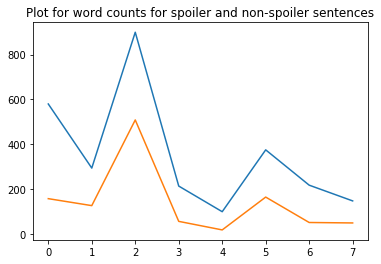

'\n Blue graph indicates count of words for sentences labelled as spoiler \n Red graph indicates count of words for sentences labelled as non-spoiler \n'

In [4]:
words = ['kill', 'die', 'end', 'death', 'finale', 'turn', 'reveal', 'murder']
non_spoiler_word_counts = np.array([ 159, 128, 509, 58, 20, 166, 53, 51])
spoiler_word_counts = np.array([ 580, 295, 899, 215, 101, 376, 219, 149])

x = np.arange(8)
plt.plot(x, spoiler_word_counts.T, x, non_spoiler_word_counts.T)
plt.title("Plot for word counts for spoiler and non-spoiler sentences")
plt.show()

"""
 Blue graph indicates count of words for sentences labelled as spoiler 
 Red graph indicates count of words for sentences labelled as non-spoiler 
"""
